# Introduction to hypothesis testing

Let's say you have a large bag with red, green, and blue balls, and you stick your hand in the bag and draw a dozen balls out. All the balls in the large bag is what we call the **population** and the dozen balls we drew are a **sample**. **Probability** is concerned with what our draw looks like based on how many balls of each color we have in the large bag. In other words, probability asks, given what we have in the population, what should the sample look like. **Statistics** asks the opposite: Given what color balls we drew, what can we say about the composition of balls in the population. In other words, given what we see in the sample, what can we conclude about the population? Drawing conclusions about the population based on the sample is called **statistical inference**.

At the conclusion of this lesson you should be able apply basic classical hypothesis tests to some common situations. In addition to the usual libraries, we will also be using `statsmodels` and `scipy` for many of our examples. Let's begin by loading all the libraries. In this notebook we cover the following examples of tests of hypothesis:

- Two sample tests for continuous variables
- Two sample tests for categorical or count data
- Test for distributions

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize': (8, 12)})
import matplotlib.pyplot as plt

import scipy
import scipy.stats as ss
import numpy.random as nr
import statsmodels
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.power as sp
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

We will use a dataset derived from Vladimir Belyaev's [steamdb database](https://github.com/leinstay/steamdb) of all the games offered on the Steam platform to look at various examples of statistical tests. The curated subset of games was restricted to those with complete information and high popularity. It has the following columns:
- name: video game name 
- store_uscore - store.steampowered.com user's score
- igdb_uscore  - igdb.com critic's score
- meta_score - metacritic.com critic's score
- gfq_rating - gamefaqs.gamespot.com user ratings
- windows_only: Available for Windows OS exclusively, or also on Mac / Linux
    - 0: Available on other OS
    - 1: Windows OS exclusive
- price: December 2022 price on steampowered.com
    - 1: < $19.99
    - 2: $19.99 - $24.99
    - 3: > $24.99
- difficulty: gamefaqs.gamespot.com difficulty rating
    - 1: Simple / Easy
    - 2: Just Right
    - 3: Tough / Unforgiving
- time: howlongtobeat.com main story completion time in hours
    - 1: <= 6 hours
    - 2: 7 - 10 hours
    - 3: 11 - 20 hours
    - 4: 21+ hours
- popularity: igdb.com popularity rating. A minimum score of 5 was used to eliminate unpopular games.
    - 1: popularity 5-25
    - 2: popularity > 25

In [4]:
scores = pd.read_json('./data/steamdb_popular.json')
scores.head()

,name,store_uscore,igdb_uscore,meta_score,gfq_rating,windows_only,price,difficulty,time,popularity
0,Half-Life,96,90,96,4.23,0,1,3,3,1
1,Half-Life 2,97,91,96,4.40,0,1,2,3,1
2,Portal,98,88,90,4.33,0,1,2,1,1
3,Half-Life 2: Episode Two,96,88,90,4.26,0,1,2,1,1
4,Left 4 Dead 2,97,83,89,4.01,0,1,2,2,1


### Student's t-test for comparing averages

The difference in means between two normal distributions with unknown variance follows a t-distribution. The t-test is one of the oldest and most widely used classical hypothesis tests. It can be used to

- test whether a population mean has a specified value (**one-sample** t-test).
- test the difference between two means  of two samples (with equal, or unequal variances) (**two-sample** t-test)
- test a paired-response difference from zero, e.g., a before/after drug treatment on patients (**paired** t-test)
- test whether the slope of a line is not zero (covered later in class)
- test the importance of variables (covered later in class)

As a first example, compare the average metacritic score for windows only releases vs multi-platform games:

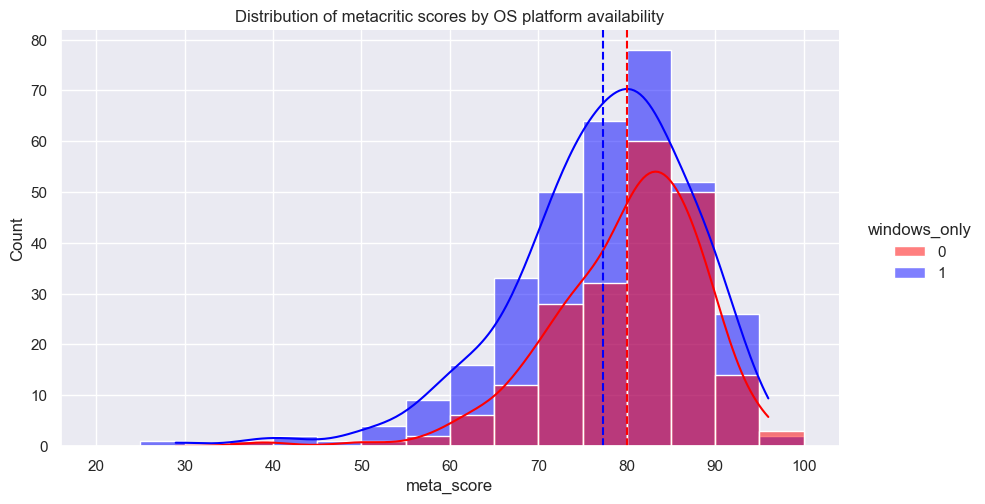

In [6]:
windows = scores.loc[scores['windows_only'] == 1, 'meta_score']
multi_platform = scores.loc[scores['windows_only'] == 0, 'meta_score']

bins = [x for x in range(20,101,5)]

sns.displot(data = scores,
            x = 'meta_score', 
            hue = scores['windows_only'], 
            bins = bins, 
            palette = {0:'red', 1:'blue', 'desat':0.5},
            kde = True,
            aspect = 1.75)

plt.title('Distribution of metacritic scores by OS platform availability')
plt.axvline(windows.mean(), 0, color = 'blue', linestyle = '--')
plt.axvline(multi_platform.mean(), 0, color = 'red', linestyle = '--');

Notice that the values of the distributions of these populations overlap quite a bit and the means are close. The question is, are these differences significant?  

You can now compute the two-sample t-test to determine if the difference of means is significant. A number of summary statistics are computed and printed for the test. The two-sided t-test is used to determine if we can reject the **null hypothesis that the difference of means is not significant**.

We can try to implement the t-test manually based on what is described [in this Wikipedia article](https://en.wikipedia.org/wiki/Student%27s_t-test):

In [9]:
n_win, n_multi = windows.size, multi_platform.size
mean_win, mean_multi = windows.mean(), multi_platform.mean()
var_win, var_multi = windows.var(), multi_platform.var()
var_P = var_win / n_win + var_multi / n_multi #welch's two-sample t-test

t_stat = (mean_win - mean_multi) / var_P**0.5 #welch's two-sample t-test
deg_f = var_P ** 2 / ((var_win / n_win)**2 / (n_win - 1) + (var_multi / n_multi)**2 / (n_multi - 1)) #welch's two-sample t-test
p_val = ss.t.cdf(t_stat, df = deg_f) * 2

print("statistic = {} and p-value = {}".format(t_stat, p_val))

statistic = -3.37363532365676 and p-value = 0.0007993946558384921


And we can see that we obtain a p-value of around 0.0008. Since this p-value is very low, we reject the null hypothesis and conclude that the two population means are significantly different.

Instead of doing all the calculation manually, which can be a tedious, we can also use the `statsmodels` package to take care of the computation for us and present us with the results (including additional calculations such as confidence intervals):

In [11]:
def t_test(a, b, alpha = 0.05, alternative = 'two-sided', type = 'independent'):

    diff = a.mean() - b.mean()
    if type == 'independent':
        res = ss.ttest_ind(a, b, equal_var = False)
    elif type == 'paired':
        assert(len(a) == len(b))
        res = ss.ttest_rel(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha = alpha, alternative = alternative, usevar = 'unequal') #cant find
    degfree = means.dof_satt()

    index = ['deg_of_freedom', 'observed_difference', 't-statistic', 'p_value', 'low_95_CI', 'high_95_CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

t_test(windows, multi_platform)

deg_of_freedom         500.195335
observed_difference     -2.710590
t-statistic             -3.373635
p_value                  0.000799
low_95_CI               -4.289167
high_95_CI              -1.132012
dtype: float64

Either way we get the same t-statistic and p-value. Examine these statistics noticing the following:

1. Difference in means is not enormous, 2.7 points on a 100 point scale, and the populations overlap quite a bit, but the t-statistic is large in absolute value and the p-value is small. Therefore, there is a small chance that the difference in means is from random variation alone. 
3. The 95% confidence interval does not straddle 0.  

Based on these statistics we can reject the null hypothesis and conclude that the two samples did not come from populations with the same mean.

## Statistical power analysis

The **power of a test** is formally defined $\text{power} = P(\text{reject } H_0| \text{ when } H_0 \text{ is false})$. In plain language, the power of a test is the probability of finding a true effect to be a significant effect. A test with insufficient power will not detect a significant effect even when it should. Clearly, we want the most powerful test we can find for the situation. Computing power can be a bit complex, and analytical solutions can be difficult or impossible. Often, a simulation is used to compute power.

Let's look at the example of computation power for the two sample t-tests for the difference of means. The power of this test depends on the several parameters:

- the number of samples
- the difference in the sample means standardized by their overall variability (also known as the **effect size**)
- the type of test

When running a power test, you can ask several questions that will assist you in designing an experiment. Usually, you will determine how big a sample you need to have a good chance of rejecting the null hypothesis. You can also determine how big an effect needs to be given a fixed sample size (all the samples you have or can afford) to have a good chance of rejecting the null hypothesis. 

The `statsmodels` package provides power calculations for a limited set of hypothesis tests. We can use these capabilities to examine the power. We can use it to find the right sample size for an effect size.


The `statsmodels` package provides power calculations for a limited set of hypothesis tests. We can use these capabilities to examine the power. We can use it to find the right sample size for a effect size.

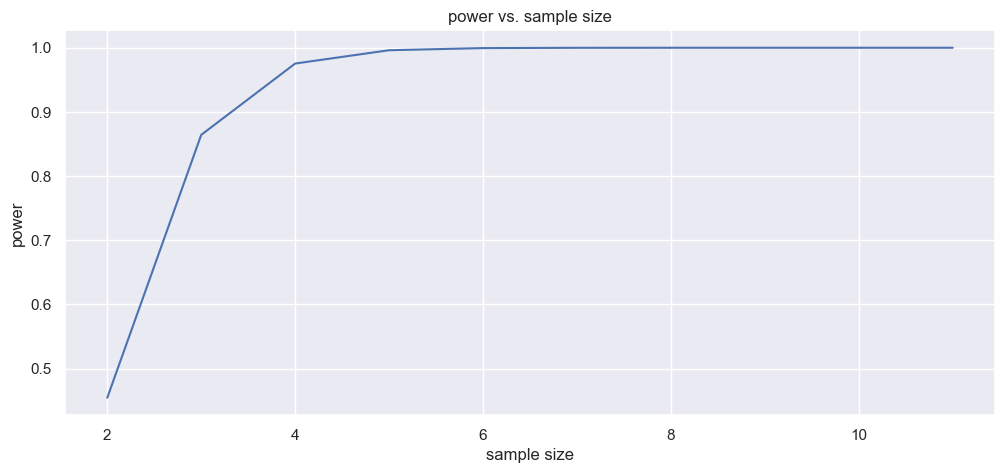

In [14]:
sample_size = np.arange(start = 2, stop = 12, step = 1)
power = [sp.tt_ind_solve_power(effect_size = abs(t_stat), nobs1 = n, alpha = 0.05, 
                               power = None, ratio = 1.0, alternative = 'two-sided') 
          for n in sample_size]

fig, ax = plt.subplots(1,1,figsize = (12,5))
sns.lineplot(x = sample_size, y = power, ax=  ax)
plt.title('power vs. sample size')
plt.xlabel('sample size')
plt.ylabel('power');

In practice, less than $80\%$ power for a test is not good. We can also use it to find the right effect size for a given sample size.

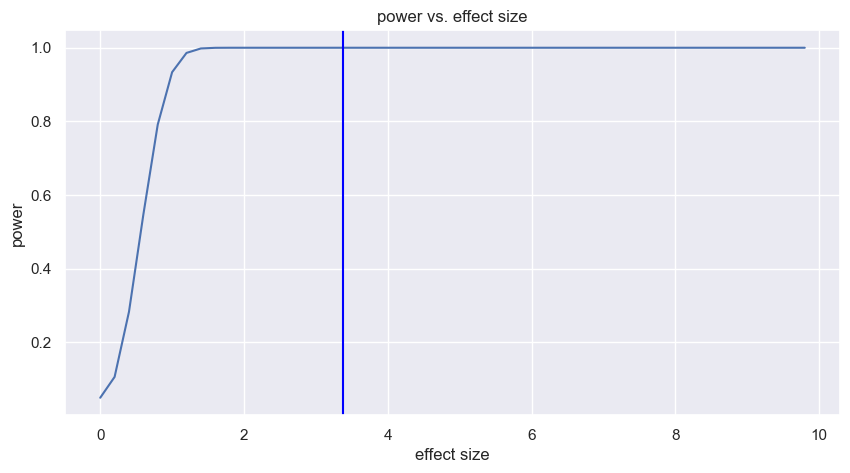

In [16]:
effect_size = np.arange(start = 0.0, stop = 10.0, step = .2)
power = [sp.tt_ind_solve_power(effect_size = x, nobs1 = 25, alpha = 0.05, 
                               power = None, ratio = 1.0, alternative = 'two-sided') 
          for x in effect_size]

fig, ax = plt.subplots(1, 1, figsize =(10,5))
sns.lineplot(x = effect_size, y = power, ax = ax)
plt.axvline(abs(t_stat), 0, color = 'blue') # marks the observed effect
plt.title('power vs. effect size')
plt.xlabel('effect size')
plt.ylabel('power');

Examine these results and notice how the power of the t-test rapidly increases as the difference in means increases. At a relatively small difference in means the power of the test is approaching 1.0, the maximum possible. 

### Exercise 

- Find out if there is a significant difference in metacritic scores between platform distributions (`windows_only`) if we limit the data to the most popular games only: `popularity` == 2:

In [19]:
scores_subset = scores.loc[scores['popularity'] ==2, :] #creates a sub-group of popular games only (where popularity = 2)
windows = scores_subset.loc[scores['windows_only'] == 1, 'meta_score'] #creates a subset of popular windows games and their score
multi_platform = scores_subset.loc[scores['windows_only'] == 0, 'meta_score'] #creates a subset of popular other-platform games and their scores
t_test(windows, multi_platform) #compares the two samples for the t-test

deg_of_freedom         137.049517
observed_difference     -2.279199
t-statistic             -1.250200
p_value                  0.213357
low_95_CI               -5.884178
high_95_CI               1.325780
dtype: float64

- Find out if there is a significant difference between user scores on IGDB (`igdb_uscore`) and on Steam, (`store_uscore`) for the most popular games (`popularity` == 2). HINT: For this you need to perform a paired t-test.

In [21]:
pop_igdb = scores.loc[scores['popularity'] == 2, 'igdb_uscore'] #create subgroup of popular games with IGDB score
pop_store = scores.loc[scores['popularity'] == 2, 'store_uscore'] #create subgroup of popular games with steam score
t_test(pop_igdb, pop_store, type = 'paired') #compare with paired t-test

deg_of_freedom         2.993889e+02
observed_difference   -7.105960e+00
t-statistic           -7.749104e+00
p_value                1.291418e-12
low_95_CI             -1.000782e+01
high_95_CI            -4.204105e+00
dtype: float64

Since $P-value < \alpha$, we reject the null hypothesis and conclude that IGDB and Steam scores for popular games are significantly different from each other.

We saw that we can fail to reject the null hypothesis if the test lacks power. Let's investigate that.

- Plot 100 values for effect size ranging from $0.0$ to $10.0$ and measure the effect size required for the above test.

Text(0, 0.5, 'power')

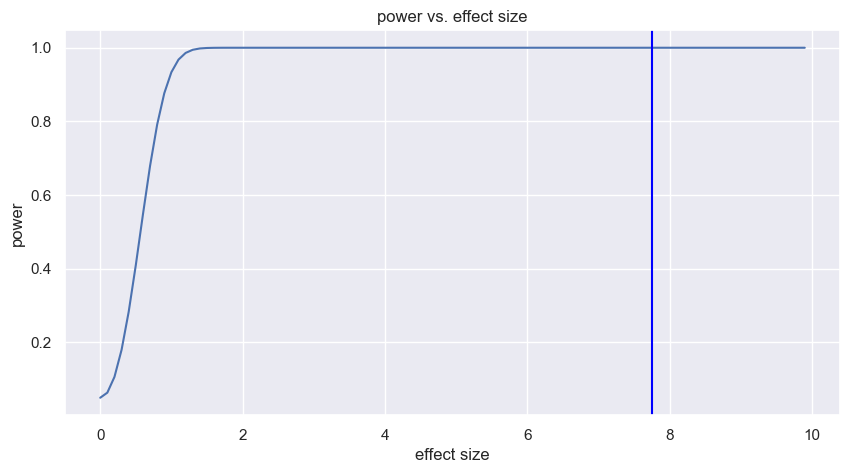

In [24]:
effect_size = np.arange(start = 0, stop = 10, step = 0.1)
t_stat = t_test(pop_igdb, pop_store, type= 'paired')['t-statistic']
power = [sp.tt_ind_solve_power(effect_size = x, nobs1 = 25, alpha = 0.05, power = None, ratio = 1.0, alternative = 'two-sided') for x in effect_size]

fig, ax = plt.subplots(1, 1, figsize = (10,5))
sns.lineplot(x = effect_size, y = power, ax = ax)
plt.axvline(abs(t_stat), 0, color = 'blue') #marks the observed effect
plt.title('power vs. effect size')
plt.xlabel('effect size')
plt.ylabel('power')

### End of exercise

## Tests for categorical data

The t-test is used on continuous data. What if we have categorical data?

### Chi-squared tests

We use Chi-squared (also written as $\chi^2)$ tests to compare counts in different categories, where the categories are mutually exclusive.

- A Chi-squared **goodness of fit** test (also called **test of proportions** or **Pearson's Chi-squared test**) is used to test if the sample is representative of the population. For example, if we survey people randomly in Washington State, we can test if the number of respondents in Seattle is significantly different from the expected probability based on Seattle's percentage of the state population.
- The Chi-squared **test of independence** (also called **test of association**) tests whether two categorical variables are related to each other. It does so by comparing observed counts to counts we should expect if the two variables are independent.

The name Chi-squared comes from a corresponding probability distribution. It's density depends on a parameter we call **degrees of freedom**, which is greater the bigger the sample size.

![](https://library.startlearninglabs.uw.edu/DATASCI410/img/Chi-square.png)

As with any probability density function, confidence intervals and p-values can be computed. Notice that the $\chi$-squared distribution becomes flatter and with greater dispersion as the degrees of freedom increase. In practice, this means that you will need large samples to get a meaningful result if you have too many choices in your test.

#### Chi-squared test of proportion example

Here's an example of the Chi-squared goodness of fit: The traditional way to apply a chi-squared test is to first create a chi-squared table. In this example we are looking at the results of an A-B test with three possible outcomes. This type of test might be applied to determine if a new web site drives more customer purchases.

The code in the cell below builds a simple chi-squared table. The data we have are

- actual occurrence of events
- expected probability of these events (based on the distribution of the null hypothesis)

From the above data we then calculate the following

- the expected occurrence of events given the expected probabilities
- the difference between the occurrence and the expected number of events
- the square of the difference
- the squared difference normalized by the expected number of occurrences

The sum of the figures in the last column is the Chi-squared statistic. In other words 

$$\chi^2_{\text{statistic}} = \sum_{i = 1}^k \frac{(o_i - e_i)^2}{e_i}$$ 

where we have $k$ groups, $o_i$ is the observed count for group $i$ and $e_i$ is the expected count for group $i$ based on the hypothesized proportions. Under $H_0$ we assume $\chi^2_{\text{statistic}} \sim \chi^2(k-1)$ where $k-1$ are the degrees of freedom.

In the complete steamdb dataset, proportion of games in the price brackets for `price` (1: < $19.99, 2: $19.99 - $24.99, 3: > $24.99)
is 88 percent for low, 8 percent for middle and 4 percent for high. Here are the counts we observe in the data:

In [28]:
all_prices = [0.88, 0.08, 0.04]
price_counts = scores['price'].value_counts(sort = False)
price_counts

price
1    172
2    182
3    194
Name: count, dtype: int64

We can manually compute the $\chi^2$ statistic as such:

In [30]:
price_data = pd.DataFrame({'price': ['low', 'middle', 'high'],
                         'observed_count': price_counts,
                         'hypothesized_proportion': all_prices})

total_count = price_data['observed_count'].sum()
price_data['expected_count'] = total_count * price_data['hypothesized_proportion']

price_data['diff_squared'] = (price_data['observed_count'] - price_data['expected_count'])**2
price_data['diff_normalized'] = price_data['diff_squared'] / price_data['expected_count']

chi_squared_statistic = price_data['diff_normalized'].sum()
print("chi_squared_statistic = {}".format(chi_squared_statistic))
price_data

chi_squared_statistic = 1985.8835434638352


,price,observed_count,hypothesized_proportion,expected_count,diff_squared,diff_normalized
price,,,,,,
1,low,172,0.88,482.24,96248.8576,199.587047
2,middle,182,0.08,43.84,19088.1856,435.405693
3,high,194,0.04,21.92,29611.5264,1350.890803


We have $3-1 = 2$ degrees of freedom for the $\chi^2$ distribution. We can get a p-value for this statistic now:

In [32]:
1 - ss.chi2.cdf(chi_squared_statistic, df = 2)

0.0

This p-value is rather small, so we reject the null hypothesis. In other words, assuming the hypothesized proportions for each group, there is little chance that the differences between the observed and expected occurrences are the result of random variation alone.

In the foregoing example we computed the chi-squared statistic and p-value directly. In general, this is a somewhat cumbersome approach. Instead, we can use the `chisquare` function from the `scipy.stats` package as shown in the code below.

In [34]:
chi_sq_stat, p_value = ss.chisquare(price_data['observed_count'], price_data['expected_count'])
print('Chi-squared statistic = {} and p-value = {}.'.format(str(chi_sq_stat), str(p_value)))

Chi-squared statistic = 1985.8835434638352 and p-value = 0.0.


Finally, we should check the power of our test. First we compute our observed effect size:

In [36]:
eff_size = statsmodels.stats.gof.chisquare_effectsize(price_counts / price_counts.sum(), all_prices)
eff_size

1.2210914527191836

We can see where we are by plotting effect size against power:

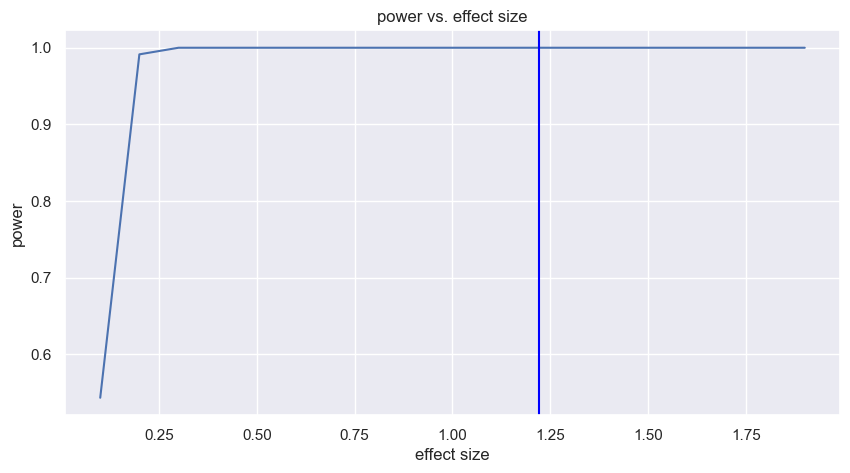

In [38]:
effect_size = np.arange(start = 0.1, stop = 2.0, step = 0.1)
power = sp.GofChisquarePower().solve_power(effect_size = effect_size, nobs = price_counts.sum(), 
                                           n_bins = 3, alpha = 0.05)

fig, ax = plt.subplots(1, 1, figsize =(10,5))
sns.lineplot(x = effect_size, y = power, ax = ax)
plt.axvline(abs(eff_size), 0, color = 'blue') # marks the observed effect
plt.title('power vs. effect size')
plt.xlabel('effect size')
plt.ylabel('power');

Apparently, this test is quite powerful, and we could have detected much smaller differences between the observed and expected counts.

Let's perform a Chi-squared test of independence to see if two categorical variables are related or not. Let's see if the difficulty of a game is related to the time it takes to complete it

In [40]:
ct = pd.crosstab(scores['time'], scores['difficulty'])
ct

difficulty,1,2,3
time,,,
1,51,37,32
2,31,72,43
3,21,72,51
4,21,62,55


In [41]:
chi_sq_stat, p_value, dof, ct_expected = ss.chi2_contingency(ct)
print('Chi-squared statistic = {} and p-value = {}.'.format(str(chi_sq_stat), str(p_value)))

Chi-squared statistic = 39.57002165491135 and p-value = 5.532909906370904e-07.


We can also calculate the effect size by flattening the observed and expected counts tables and turning counts into percentages.

In [43]:
obs = ct.values.ravel() / ct.values.sum() # flattens an input array into a contiguous 1D array
exp = ct_expected.ravel() / ct_expected.sum()

eff_size = statsmodels.stats.gof.chisquare_effectsize(obs, exp)
eff_size

0.2553160123380681

If we return to the chart of power vs effect size we would see that this test has just enough power.

## Testing distributions

Tests of hypotheses often make distributional assumptions. This raises the question of how can we test if our data fits some distribution. To answer this question we will now look at both graphical and formal tests. Since in most cases, distribution assumptions are approximate, simple graphical methods are often sufficient.

### The Q-Q plot

The quantile-quantile (Q-Q) plot provides a handy visual means to inspect the similarity of distributions of a data set. The general idea is to plot the quantiles of the sample on the vertical axis and the quantiles of the theoretical distribution on the horizontal axis. If the points of the plot fall on an approximately straight line, you can conclude that the sample distribution is close to the theoretical. 

The normal Q-Q plot plots the quantiles of a standard normal distribution on the horizontal axis and the quantiles of the data sample on the vertical axis. If the sample is normal the data points will fall in a straight line. 

Run the code in the cell below to create Q-Q plots of the two samples, and examine the results.

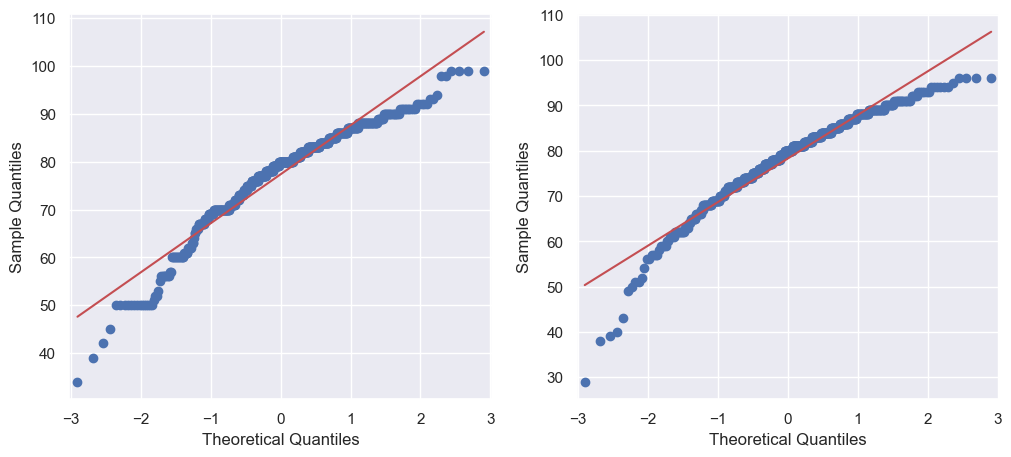

In [46]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,5))
sm.qqplot(scores['igdb_uscore'], line = 's', ax = axs[0])
sm.qqplot(scores['meta_score'], line = 's', ax = axs[1]);

The line of points on both Q-Q plots is close to straight, but with significant deviations on the tails indicating less dispersion than a standard normal distribution.

We can also visualize the **cumulative density functions** (CDFs) of the two samples. To make things easier, here's a function that plots cumulative distributions for each sample.

In [48]:
def plot_cums(dist1, dist2, labels = ['sample 1', 'sample 2']):
    plt.figure(figsize = (10, 6))
    p = np.arange(len(dist1)) / (len(dist1) - 1) # calculate the proportional values of samples

    data_sorted = np.sort(dist1) # sort the first data sample
    sns.lineplot(x = data_sorted, y = p)
    
    data_sorted = np.sort(dist2) # sort the second data sample:
    sns.lineplot(x = data_sorted, y = p)

    plt.title('empirical CDFs of two datasets')
    plt.xlabel('range of data')
    plt.ylabel('percentile')
    plt.legend(labels = labels)

    return None

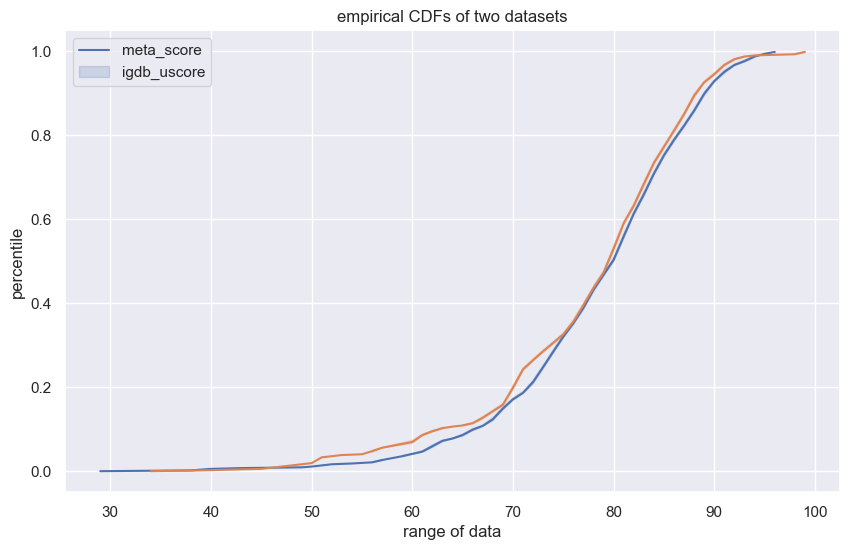

In [49]:
plot_cums(scores['meta_score'], scores['igdb_uscore'], labels = ['meta_score', 'igdb_uscore'])

Note that since IGDB and Metecritic scores are on the same scale we didn't need to rescale the data, but in general we need to rescale the data prior to comparing the distributions. The GameFAQ ratings are on a 5 point scale, so we can directly compare with the 100 point ratings by normalizing the columns. 

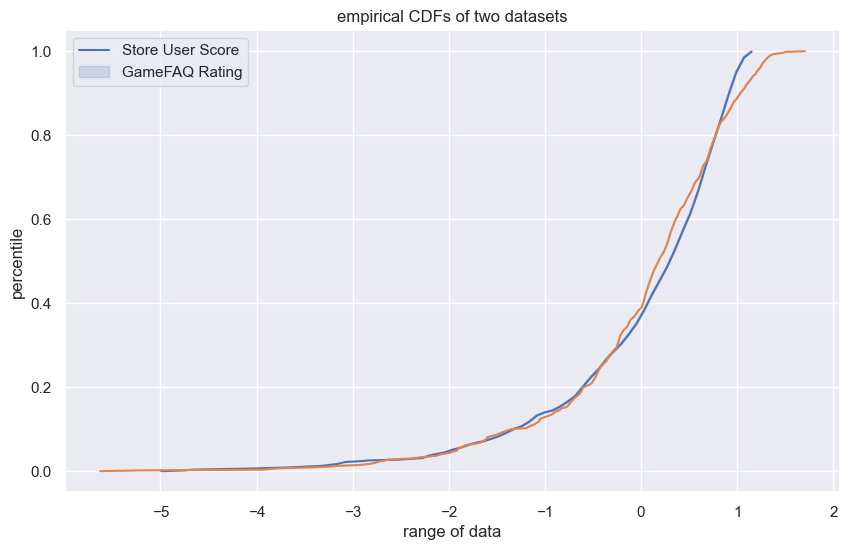

In [51]:
store_norm = (scores['store_uscore'] - scores['store_uscore'].mean()) / scores['store_uscore'].std()
gfq_norm = (scores['gfq_rating'] - scores['gfq_rating'].mean()) / scores['gfq_rating'].std()

plot_cums(store_norm, gfq_norm, labels = ['Store User Score', 'GameFAQ Rating'])

Notice that, as you might expect, the two CDFs are quite similar, indicating that the two samples are drawn from the same distribution. But are the deviations significant? We can answer that more formally using the **Kolmogorov-Smirnov test**.

### The Kolmogorov-Smirnov test

We can test whether a sample follows a theoretical distribution or if two distributions are significantly different by using the Kolmogorov-Smirnov test. The K-S statistic is just the maximum vertical distance between the CDF of the sample and the CDF of the theoretical distribution, or the CDFs of two independent samples. Since it is based on a simple deviation, the K-S test can test departure from any hypothetical distribution, not just normal.

The **K-S statistic is the maximum vertical difference** between the two cumulative density functions. Based on this distance and the number of samples, the p-value for the K-S test is computed. It is important that the **samples must be standardized** before applying the K-S test.

In [54]:
# compare user score on the Steam store with a standard normal
ss.kstest(store_norm, 'norm')

KstestResult(statistic=0.14832432994074274, pvalue=5.476856139028006e-11, statistic_location=0.033313820365882665, statistic_sign=-1)

In [55]:
# compare user score on the Steam store with GameFAQs user's scores
ss.kstest(store_norm, gfq_norm)

KstestResult(statistic=0.08941605839416059, pvalue=0.02496982005033905, statistic_location=1.069679131660865, statistic_sign=1)

The p-value is small when compared with a standard normal, therefore we reject the null hypothesis that the data is normally distributed (with $\mu = 0$ and $\sigma = 1$). In other words, assuming that the data is normally distributed, a sample like ours is quite unusual.

The p-value when comparing the user ratings on two different platforms shown a much more similar distribution even though the raw scales were different. 

The K-S test is rather general, as it can be applied to test any distribution. However, this means that the **power** of this test is limited. The power of a test is the probability of rejecting a null hypothesis when the alternative is true. 

As is always the case with classical statistics, a more powerful test can be created by adopting more restrictive assumptions. For example, the Shapiro-Wilk test has greater power, but is specifically for normal distributions. 

## Testing multiple groups with ANOVA

So far, we have only looked at tests for comparing two samples. What if we have multiple groups and we wanted to compare their means? Why can’t we just do multiple two-sample t-tests for all pairs? Because doing so results in increased probability of accepting a false hypothesis; e.g., if we had 7 groups, there would be $7 \choose 2$ $=21$ pairs to test.  Recall that the $\alpha$ cutoff is the probability of committing a type-I error, so if $\alpha = 0.05$ for any one test then we have a 95% probability of rejecting $H_0$ correctly. But this probability drops as we perform more tests: for 21 tests it is $0.95^{21} \approx 0.34$!

This problem is known as the problem of **multiple comparisons** or **base rate fallacy**. With large numbers of groups, there is a high probability of getting a false positive (type I error). Several adjustments to the multiple comparisons problem have been proposed, such as the **Bonferroni correction**: instead of $\alpha$ we use $\alpha_b = \frac{\alpha}{k}$ (where $k$ is the number of groups) as our p-value threshold. This tends to be a conservative approach that won't work well if $k$ is very high. There are other approaches that we won't get into here.

Instead of trying to find out all possible significant effects like we do above, we can first perform a test to see if there are *any* significant effects, without necessarily knowing which:

- Null hypothesis: All groups are samples from the same population.
- Alternative hypothesis: At least one group has a statistically different mean.

This type of analysis is called “ANalysis Of VAriance”, or ANOVA for short. ANOVA is one of a large family of models used for **experimental design**.

Let's have a look at how we would perform the comparisons between the multiple groups of data. First, make data independence and normality assumptions about the groups. Let $k$ be the number of treatment groups, $n$ be the number of data points and SS be the sum of squares. We can split total sum of squares **SSTotal** into the sum of squared errors *between* treatments **SST** and the sum of squared errors *within* treatments **SSE**: SSTotal = SST + SSE. We can divide each by its corresponding degrees of freedom to get the mean squared error between treatments **MST** and the mean square error within treatments **MSE**. Finally we can compute the F-statistic and derive the p-value by referring to the [F distribution](https://en.wikipedia.org/wiki/F-distribution). 

We leave out the details of the exact calculations, and instead we summarize the results in an ANOVA table as follows:

|Type|Sum of Squares|degrees of freedom|Mean Square E|F|Significance|
|---|:---:|:---:|:---:|:---:|:---:|
|between groups|SST|$k-1$|SST / $k-1$|F-statistic| p-value|
|within groups|SSE|$n-k$|SSE / $n-k$|||
|total|SSTotal|$n-1$||||

Let's now see an example. Let's say we wanted to test if on average the Metacritic scores are different for games with degrees of difficulty.

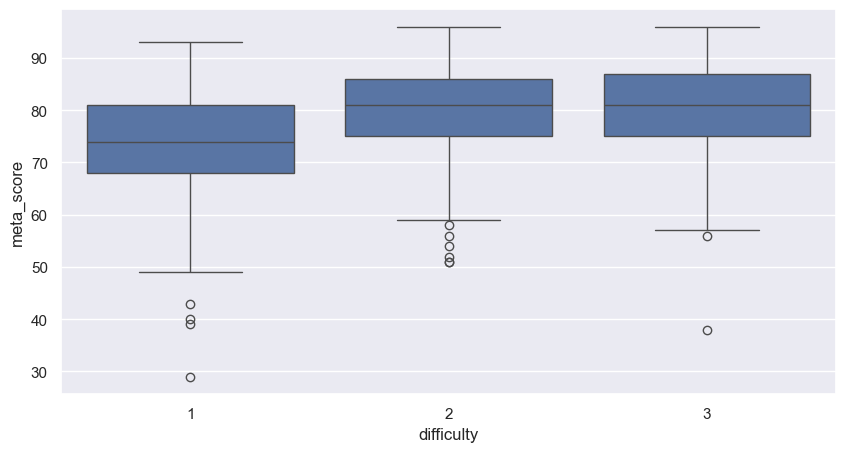

In [58]:
fig, ax = plt.subplots(nrows= 1, ncols=1, figsize=(10,5))
sns.boxplot(x = 'difficulty', y = 'meta_score', data = scores, ax= ax);

The plot shows variation between the distributions of the groups, but are any of these differences significant? To answer that we use an ANOVA test:

In [60]:
model = ols('meta_score ~ C(difficulty)', data = scores).fit() #'col_in ~ C(col_out)', data = df
anova_table = sm.stats.anova_lm(model)
print(anova_table)

                  df        sum_sq      mean_sq          F        PR(>F)
C(difficulty)    2.0   3771.171993  1885.585997  21.904973  7.076557e-10
Residual       545.0  46913.747715    86.080271        NaN           NaN


The F statistic is fairly large and the p-value is small. So we reject the null hypothesis and conclude that there are significant differences between the different groups.

Note that ANOVA isn't just a test, but also a statistical model. This means that once we fit it to the data, we can then use it to obtain predictions:

In [62]:
model.predict({'difficulty': [1, 2, 3]}) # we get a unique prediction for each value of difficulty

0    73.451613
1    79.810700
2    79.591160
dtype: float64

Let's draw the distribution (histogram) of the actual scores:

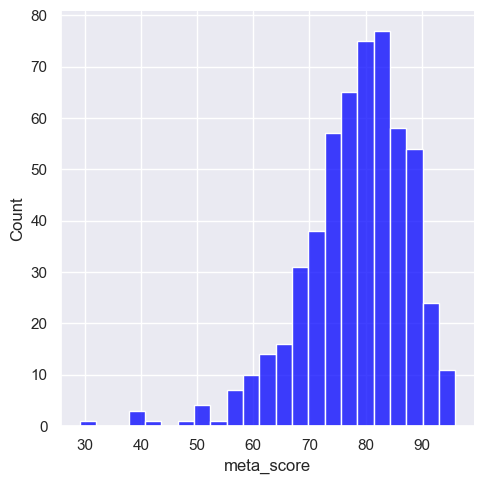

In [64]:
sns.displot(scores['meta_score'], 
            kde = False, 
            color = 'blue');

We can see that the predicted scores are less varied than the actual scores. In fact, the model predicts only three distinct scores. This should not come as a surprise, since we trained a model to predict the Metacritic score using **only** the `difficulty` rating from gamespot.com (ignoring all the other variables). So this model is returning a unique score for each difficulty group. We can make this model richer by adding more variables to it, but that's the topic of another lecture.

### Tukey's multiple comparison test

From the above ANOVA results we know that there is some difference in the means of these groups. However, ANOVA does not tell us which pairs of groups are significantly different from each other. From the box plot, we could make an educated guess, but one formal way of comparing groups is using **Tukey's multiple comparison** test. The test returns the following for each pairing of groups:

- the difference of the means
- the confidence interval of the difference in the means
- the p-value from the distribution of the differences

These results are laid out in a table or can be plotted graphically. Only differences in means with a confidence interval not overlapping zero are considered significant.

In [67]:
Tukey_HSD = pairwise_tukeyhsd(scores['meta_score'], scores['difficulty'])
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   6.3591    0.0  3.9527 8.7655   True
     1      3   6.1395    0.0  3.5977 8.6814   True
     2      3  -0.2195 0.9685 -2.3604 1.9213  False
---------------------------------------------------


Examine the table above. If the difference in means between the variables is significant, the confidence interval will not include 0. Which pairs have a significant difference at the 95% confidence level? You can see the results of this test in the rightmost column of the table.

# Assignment

In this assignment, we want to reinforce the concepts we covered in the lecture. Let's first load the required libraries.

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize': (10, 8)})
import matplotlib.pyplot as plt

import scipy
import scipy.stats as ss
import numpy.random as nr
import statsmodels
import statsmodels.stats as st
import statsmodels.api as sm
import statsmodels.stats.power as sp
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

We will be using the automobile mileage data for this assignment.

In [72]:
def read_auto_data(file = "./data/canadian_cars_2022.csv"):
    'Function to load the auto data set from a .csv file' 

    ## Read the .csv file with the pandas read_csv method
    df = pd.read_csv(file)
    
    ## Split the number of gears from the type of transmission, decode fuel
    df['gears'] = df['transmission'].str.extract(r'([0-9]+)').astype('Int64')
    df['gears'] = df['gears'].fillna(1) # "gearless" continuously_variable vehicles
    df['fuel'] = df['fuel'].replace({'X': 'regular_gas', 
                             'Z': 'premium_gas', 
                             'D': 'diesel'})
    df['transmission'] = df['transmission'].str.extract(r'([A-Z]+)')
    df['transmission'] = df['transmission'].replace({'A': 'automatic', 
                             'AM': 'automated_manual', 
                             'AS': 'automatic_select_shift', 
                             'AV': 'continuously_variable', 
                             'M': 'manual'})
    
    ## Remove rows with missing values
    df = df.dropna(axis = 0).reset_index(drop= True)
    return df


auto_df = read_auto_data()
auto_df.head()

,make,short_model_name,overall_length_cm,overall_width_cm,overall_height_cm,wheelbase_cm,curb_weight_kg,weight_distribution_pct_front,vehicle_class,engine_size_l,cylinders,transmission,fuel,fuel_consumption_mpg,smog,full_model_name,gears
0,acura,ilx,462.0,180.0,141.0,267.0,1415.0,60.0,Compact,2.4,4,automated_manual,premium_gas,33,3,ILX 4DR SEDAN,8
1,acura,mdx,504.0,200.0,170.0,289.0,2044.0,60.0,SUV: Small,3.5,6,automatic_select_shift,premium_gas,25,5,MDX 4DR SUV AWD,10
2,acura,rdx,474.0,190.0,167.0,275.0,1830.0,57.0,SUV: Small,2.0,4,automatic_select_shift,premium_gas,29,6,RDX 4DR SUV,10
3,acura,tlx,494.0,191.0,143.0,287.0,1781.0,57.0,Compact,2.0,4,automatic_select_shift,premium_gas,29,7,TLX 4DR SEDAN AWD,10
4,alfa romeo,stelvio,469.0,190.0,165.0,282.0,1660.0,52.0,SUV: Small,2.0,4,automatic,premium_gas,30,3,STELVIO BASE/Ti,8


In [184]:
auto_df.shape

,make,short_model_name,fuel_consumption_mpg
8,aston martin,vantage,25
17,audi,r8,20
34,bmw,z4,33
47,chevrolet,corvette,22
106,jaguar,f-type,23
125,lamborghini,aventador,13
126,lamborghini,huracan,18
148,mazda,mx-5,36
172,porsche,718,28
189,toyota,gr,34


Run the following tests on the data:

1. Test whether `fuel_consumption_mpg` and log `fuel_consumption_mpg` (using `np.log10`) follow a normal distribution. Use both a **graphical** method and a **formal** test. For the rest of this exercise, choose between using mpg or log mpg based on which of the two best fits a normal distribution. <span style="color:red" float:right>[5 point]</span>

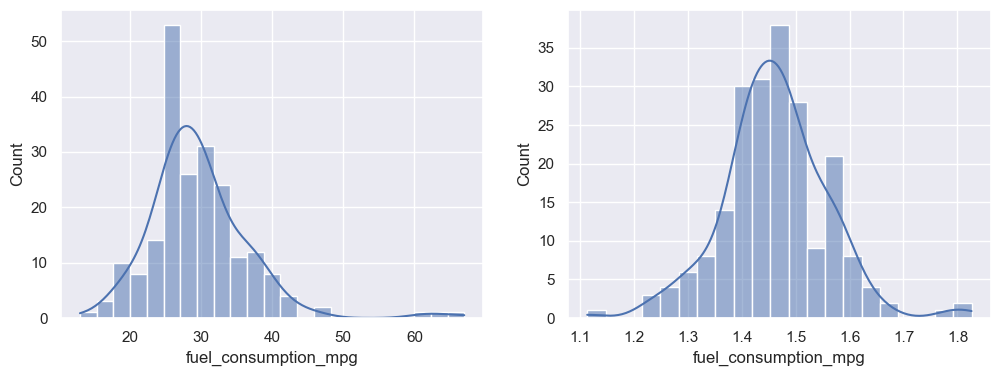

In [75]:
#Graphical method
fig, axs = plt.subplots(ncols = 2) #divide plot into 2 columns

sns.histplot(data = auto_df, x = "fuel_consumption_mpg", kde = True, ax = axs[0]) #first histogram 
#It looks mostly like a normal distribution with a skew/tail to the right

sns.histplot(data = auto_df, x = np.log10(auto_df["fuel_consumption_mpg"]), kde = True, ax = axs[1]) #second histogram
##It looks mostly like a normal distribution with a skew/tail to the right, but this was minimized by taking log

fig.set_size_inches(12, 4) #set figure size

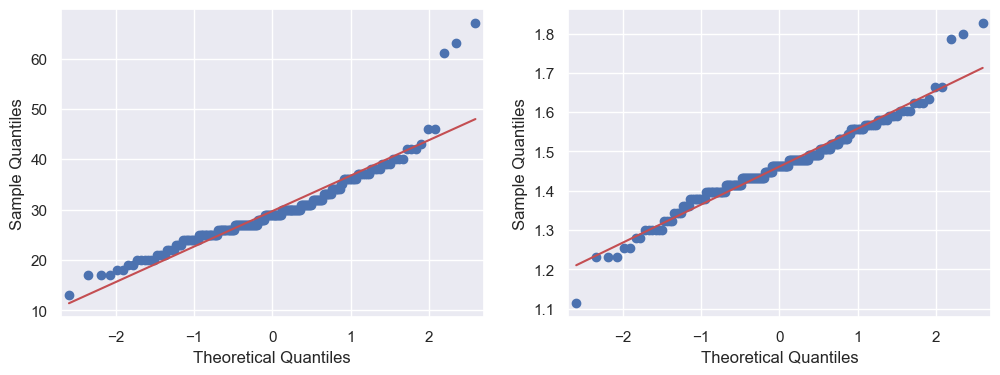

In [76]:
#formal test: QQ-plot
fig, axs = plt.subplots(ncols = 2) #divide plot into 2 columns

fig = sm.qqplot(auto_df['fuel_consumption_mpg'], line = 's', ax = axs[0]) #data, reference line = standardized line
#It seems like a mostly normal distribution since it follows the standardized line, with the exception of the tail which veers off

fig = sm.qqplot(np.log10(auto_df['fuel_consumption_mpg']), line = 's', ax = axs[1]) #data, reference line = standardized line
#It seems like a mostly normal distribution since it follows the standardized line, with the exception of the tail which veers off, 
#but this seems like this has been minized by taking the log, yet, there is now an outlier at the other end too

fig.set_size_inches(12, 4) #set figure size



We can see from the QQ plots that the data appears to be right-tailed, with a few cars having very high mileage. Using a log transformation reduces the skew, but it also pushes the lowest mileages off the normal distribution curve as well.

2. Test if the fuel consumption is significantly different for the following populations of vehicles
- "Big 3" North American brands ('buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford',  'gmc', 'jeep', 'lincoln') compared with brands that began in other countries 
- Vehicles with 1 gear vs many gears
- Vehicle with greater than median height vs less than or equal the median height

You are running separate tests for each variable. Use both graphical methods and the formal test. <span style="color:red" float:right>[5 point]</span>

In [79]:
auto_df.shape

(210, 17)

In [80]:
auto_df.make.unique()

array(['acura', 'alfa romeo', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'fiat',
       'ford', 'genesis', 'gmc', 'honda', 'hyundai', 'infiniti', 'jaguar',
       'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mercedes-benz', 'mitsubishi', 'nissan',
       'porsche', 'rolls-royce', 'subaru', 'toyota', 'volkswagen',
       'volvo'], dtype=object)

1. american vs non-american brands (cat - 2 groups - indp) --> fuel consumption (cont - dep)
    - Would this be a chi-square test? XXX b/c chi is when both var are cat--> use t-test
    - H_0: Whether the brand is American will not affect a car's fuel consumption.
    - H_a: Whether the brand is American will affect a car's fuel consumption.
2. 1 gear vs many gears (Cat - 2 groups - indep) --> fuel consumption (cont - dep)
    - Would this be another chi-square test? X --> This would be another t-test, specifically two-sample t-test, or independent samples t-test. Note: This test assumes fuel consumption is normally distributed (which we tested above).
    - H_0: The number of gears will not affect a car's fuel consumption.
            A vehicle will more than 1 gear will affect fuel consumption? 
    - H_a: THe number of gears will affect a car's fuel consumption. 
3. greater vs less height (cont) --> fuel consumption (cont - dep)
    - Would this be a t-test with two-samples? --> Yes!
    - H_0 = The vehicles height being greater than median height will NOT affect its fuel consumption.
    - H_a = The vehicles height being greater than median height WILL affect its fuel consumption. 
  
Is 210 rows of data considered a large enough sample size? 


Difference of the means: 1.504 AND difference of the standard deviations: 3.719
The test statistic is -3.59 and the critical t-statistic is -1.654
So because the t-statistic is more than the critical, then it is significant.
The p-value is 0.0 and the alpha is 0.05
So because the p-value is less than alpha, we can reject the null hypothesis.


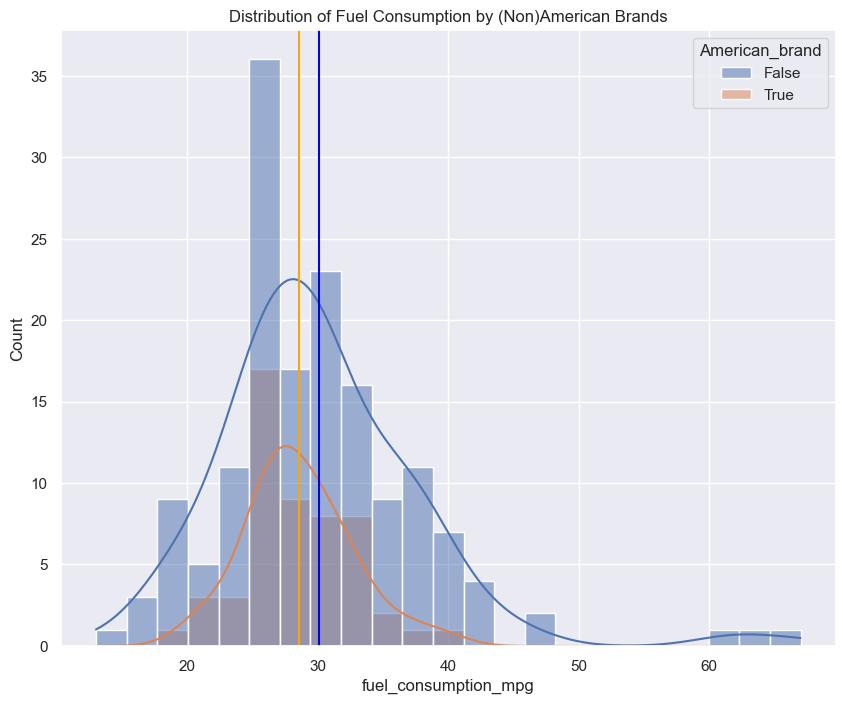

In [82]:
##Test 1
alpha = 0.05

#Create subset of data based on brands vs fuel_consumption
brand_subset = auto_df.loc[:,['make', 'fuel_consumption_mpg']] #create a subgroup of make and fuel_consump
american_brands = ['buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford', 'gmc', 'jeep', 'lincoln'] #list american brands
brand_subset['American_brand']= brand_subset['make'].isin(american_brands) #create new column of Booleans if member of this list
brand_subset.head() #print to check if dataframe looks good

#Compare with graphical method
sns.histplot(data = brand_subset, x = "fuel_consumption_mpg", hue="American_brand", kde = True) #create histogram
plt.axvline(brand_subset.loc[brand_subset["American_brand"] == False,"fuel_consumption_mpg"].mean(), 0, color = 'blue') #create vertical line at mean
plt.axvline(brand_subset.loc[brand_subset["American_brand"] == True,"fuel_consumption_mpg"].mean(), 0, color = 'orange') #create vertical line at mean
plt.title('Distribution of Fuel Consumption by (Non)American Brands')

#Compare descriptive stats to make assumptions
non_american_mean = brand_subset.loc[brand_subset["American_brand"] == False,"fuel_consumption_mpg"].mean() #find mean
american_mean = brand_subset.loc[brand_subset["American_brand"] == True,"fuel_consumption_mpg"].mean() #find mean
diff_mean= non_american_mean - american_mean #find difference between means
non_american_std = np.std(brand_subset.loc[brand_subset["American_brand"] == False,"fuel_consumption_mpg"]) #find std
american_std = np.std(brand_subset.loc[brand_subset["American_brand"] == True,"fuel_consumption_mpg"]) #find std
diff_std = non_american_std - american_std #find difference between std
print("Difference of the means:",round(diff_mean,3), "AND difference of the standard deviations:",round(diff_std,3))

#Compare with formal test: two-sample t-test
non_american_array = brand_subset.loc[brand_subset["American_brand"] == False,"fuel_consumption_mpg"] #create array
american_array = brand_subset.loc[brand_subset["American_brand"] == True,"fuel_consumption_mpg"] #create array
    #run the ttest (from statsmodels)
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(american_array,
                                        non_american_array,
                                        alternative="two-sided",
                                        usevar="unequal",
                                        value=diff_mean) 
    #look up critical t-statistic (in scipy)
tstat_crit = scipy.stats.t.ppf(alpha, df) 
print("The test statistic is",round(tstat, 3), "and the critical t-statistic is",round(tstat_crit, 3)) #compare results
print("So because the t-statistic is more than the critical, then it is significant.") #analyze
print("The p-value is", round(pvalue,2), "and the alpha is", alpha) #compare results
print("So because the p-value is less than alpha, we can reject the null hypothesis.") #analyze


In [83]:
auto_df['gears'].value_counts()

gears
8     96
9     27
7     25
6     22
10    20
1     19
5      1
Name: count, dtype: Int64

no_gears
many    191
1        19
Name: count, dtype: int64
   gears  fuel_consumption_mpg no_gears
0      8                    33     many
1     10                    25     many
2     10                    29     many
3     10                    29     many
4      8                    30     many
Difference of the means: -12.203 AND difference of the standard deviations: 0.085
The test statistic is 16.505 and the critical t-statistic is -1.652
So because the t-statistic is more than the critical, then it is significant.
The p-value is 0.0 and the alpha is 0.05
So because the p-value is less than alpha, we can reject the null hypothesis.


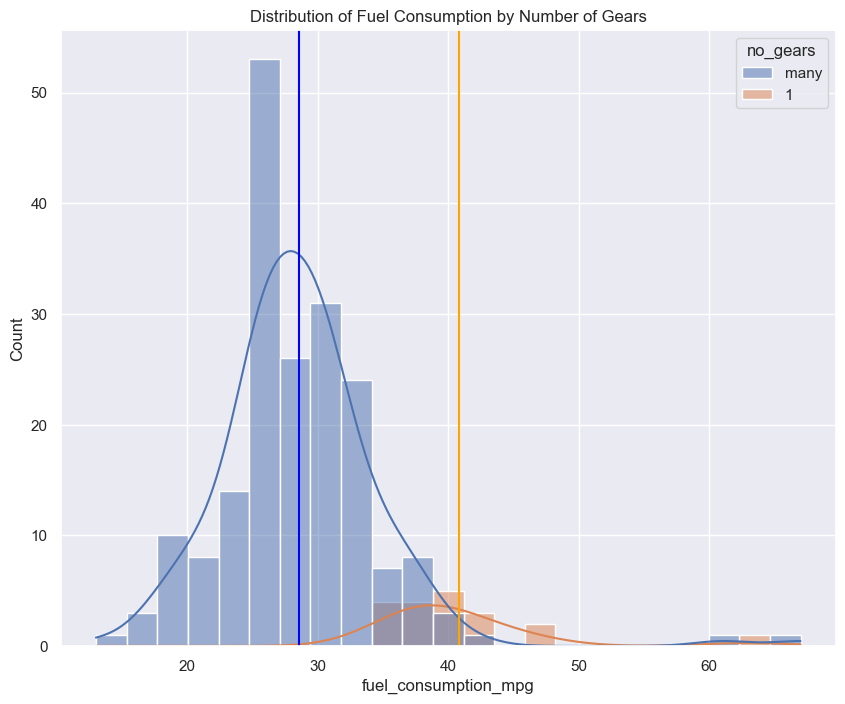

In [84]:
##Test 2
alpha = 0.05

#Create subset of data based on number of gears vs fuel_consumption
    #create a subgroup of gears and fuel_consump
gear_subset = auto_df.loc[:,['gears', 'fuel_consumption_mpg']] 
    #create new categorical column of "one" versus "many" 
    #could use filter then =, replace, or where
#gear_subset.loc[gear_subset['gears'] > 1, 'no_gears'] = "many"
#gear_subset.loc[gear_subset['gears'] == 1, 'no_gears'] = 1
gear_subset['no_gears'] = np.where(gear_subset['gears'] == 1, 1, "many") #interesting that 1 is considered a string here
    #print to check if dataframe looks good
print(gear_subset['no_gears'].value_counts())
print(gear_subset.head())

#Compare with graphical method
sns.histplot(data = gear_subset, x = "fuel_consumption_mpg", hue="no_gears", kde = True) #create histogram
plt.axvline(gear_subset.loc[gear_subset["no_gears"] == "1","fuel_consumption_mpg"].mean(), 0, color = 'orange') #create vertical line at mean
plt.axvline(gear_subset.loc[gear_subset["no_gears"] == "many","fuel_consumption_mpg"].mean(), 0, color = 'blue') #create vertical line at mean
plt.title('Distribution of Fuel Consumption by Number of Gears')

#Compare descriptive stats to make assumptions
one_gear_mean = gear_subset.loc[gear_subset["no_gears"] == "1","fuel_consumption_mpg"].mean() #find mean
many_gears_mean = gear_subset.loc[gear_subset["no_gears"] == "many","fuel_consumption_mpg"].mean() #find mean
diff_mean= many_gears_mean - one_gear_mean #find difference between means
one_gear_std = np.std(gear_subset.loc[gear_subset["no_gears"] == "1","fuel_consumption_mpg"]) #find std
many_gears_std = np.std(gear_subset.loc[gear_subset["no_gears"] == "many","fuel_consumption_mpg"]) #find std
diff_std = many_gears_std - one_gear_std #find difference between std
print("Difference of the means:",round(diff_mean,3), "AND difference of the standard deviations:",round(diff_std,3))

#Compare with formal test: two-sample t-test
one_gear_array = gear_subset.loc[gear_subset["no_gears"] == "1","fuel_consumption_mpg"] #create array
many_gears_array = gear_subset.loc[gear_subset["no_gears"] == "many","fuel_consumption_mpg"] #create array
    #run the ttest (from statsmodels)
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(one_gear_array,
                                        many_gears_array,
                                        alternative="two-sided",
                                        usevar="pooled",
                                        value=diff_mean) 
    #look up critical t-statistic (in scipy)
tstat_crit = scipy.stats.t.ppf(alpha, df) 
print("The test statistic is",round(tstat, 3), "and the critical t-statistic is",round(tstat_crit, 3)) #compare results
print("So because the t-statistic is more than the critical, then it is significant.") #analyze
print("The p-value is", round(pvalue,2), "and the alpha is", alpha) #compare results
print("So because the p-value is less than alpha, we can reject the null hypothesis.") #analyze


<Axes: xlabel='gears', ylabel='fuel_consumption_mpg'>

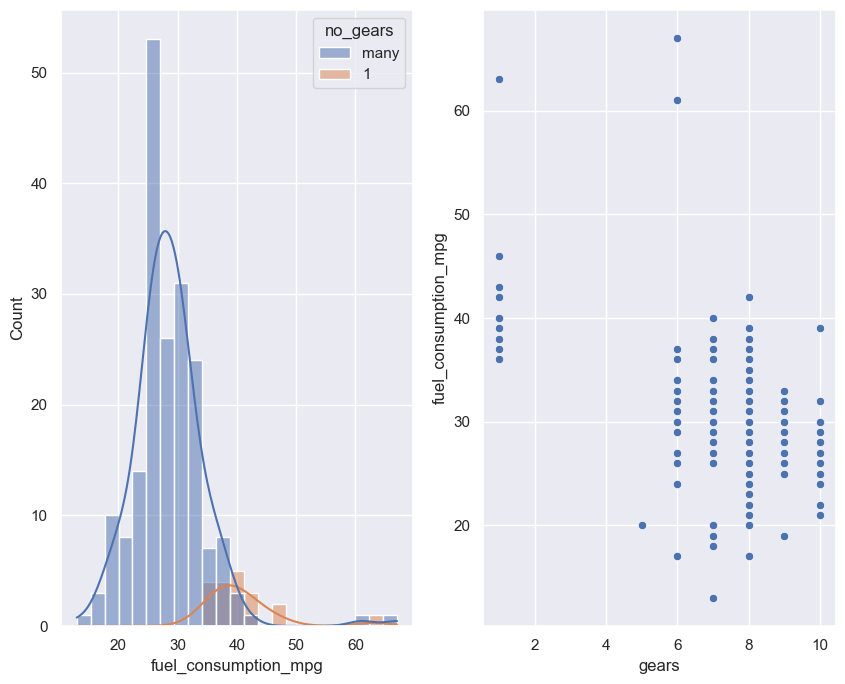

In [85]:
fig, axs = plt.subplots(ncols = 2) #divide plot into 2 columns
sns.histplot(data = gear_subset, x = "fuel_consumption_mpg", hue="no_gears", ax = axs[0], kde = True) #create histogram
sns.scatterplot(data = auto_df, x = "gears", y = "fuel_consumption_mpg", ax = axs[1]) #create a scatter plot

164.0
height
less_equal    109
greater       101
Name: count, dtype: int64
   overall_height_cm  fuel_consumption_mpg      height
0              141.0                    33  less_equal
1              170.0                    25     greater
2              167.0                    29     greater
3              143.0                    29  less_equal
4              165.0                    30     greater
Difference of the means: 4.001 AND difference of the standard deviations: 3.569
The test statistic is 0.0 and the critical t-statistic is -1.654
So because the t-statistic is LESS than the critical, then it is NOT significant.
The p-value is 1.0 and the alpha is 0.05
So because the p-value is MORE than alpha, we canNOT reject the null hypothesis.


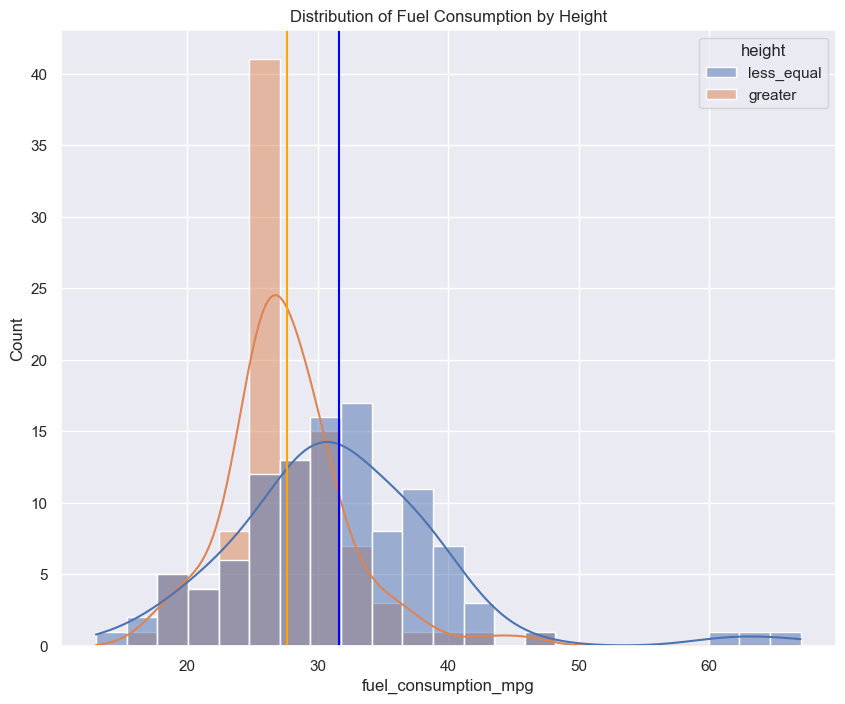

In [86]:
##Test 3
alpha = 0.05

#Create subset of data based on height vs fuel_consumption
    #create a subgroup of height and fuel_consump
height_subset = auto_df.loc[:,['overall_height_cm', 'fuel_consumption_mpg']] 
    #find the median of the 
height_subset_median = height_subset.loc[:, "overall_height_cm"].median()
    #create new categorical column of "greater" versus "less" for height compared to median
    #could use filter then =, replace, or where
height_subset['height'] = np.where(height_subset['overall_height_cm'] > height_subset_median, "greater", "less_equal")
    #print to check if dataframe looks good
print(height_subset_median)
print(height_subset['height'].value_counts())
print(height_subset.head())

#Compare with graphical method
sns.histplot(data = height_subset, x = "fuel_consumption_mpg", hue="height", kde = True) #create histogram
plt.axvline(height_subset.loc[height_subset["height"] == "less_equal","fuel_consumption_mpg"].mean(), 0, color = 'blue') #create vertical line at mean
plt.axvline(height_subset.loc[height_subset["height"] == "greater","fuel_consumption_mpg"].mean(), 0, color = 'orange') #create vertical line at mean
plt.title('Distribution of Fuel Consumption by Height')

#Compare descriptive stats to make assumptions
less_height_mean = height_subset.loc[height_subset["height"] == "less_equal","fuel_consumption_mpg"].mean() #find mean
greater_height_mean = height_subset.loc[height_subset["height"] == "greater","fuel_consumption_mpg"].mean() #find mean
diff_mean= less_height_mean - greater_height_mean #find difference between means
less_height_std = np.std(height_subset.loc[height_subset["height"] == "less_equal","fuel_consumption_mpg"]) #find std
greater_height_std = np.std(height_subset.loc[height_subset["height"] == "greater","fuel_consumption_mpg"]) #find std
diff_std = less_height_std - greater_height_std #find difference between std
print("Difference of the means:",round(diff_mean,3), "AND difference of the standard deviations:",round(diff_std,3))

#Compare with formal test: two-sample t-test
less_height_array = height_subset.loc[height_subset["height"] == "less_equal","fuel_consumption_mpg"] #create array
greater_height_array = height_subset.loc[height_subset["height"] == "greater","fuel_consumption_mpg"] #create array
    #run the ttest (from statsmodels)
tstat, pvalue, df = statsmodels.stats.weightstats.ttest_ind(less_height_array,
                                        greater_height_array,
                                        alternative="two-sided",
                                        usevar="unequal",
                                        value=diff_mean) 
    #look up critical t-statistic (in scipy)
tstat_crit = scipy.stats.t.ppf(alpha, df) 
print("The test statistic is",round(tstat, 3), "and the critical t-statistic is",round(tstat_crit, 3)) #compare results
print("So because the t-statistic is LESS than the critical, then it is NOT significant.") #analyze
print("The p-value is", round(pvalue,2), "and the alpha is", alpha) #compare results
print("So because the p-value is MORE than alpha, we canNOT reject the null hypothesis.") #analyze

###I have questions for why this couldn't reject. Graph looks similar to others. So what caused it to not be significant? 
#Check the scatter, not just the histogram!!!!!!

<Axes: xlabel='overall_height_cm', ylabel='fuel_consumption_mpg'>

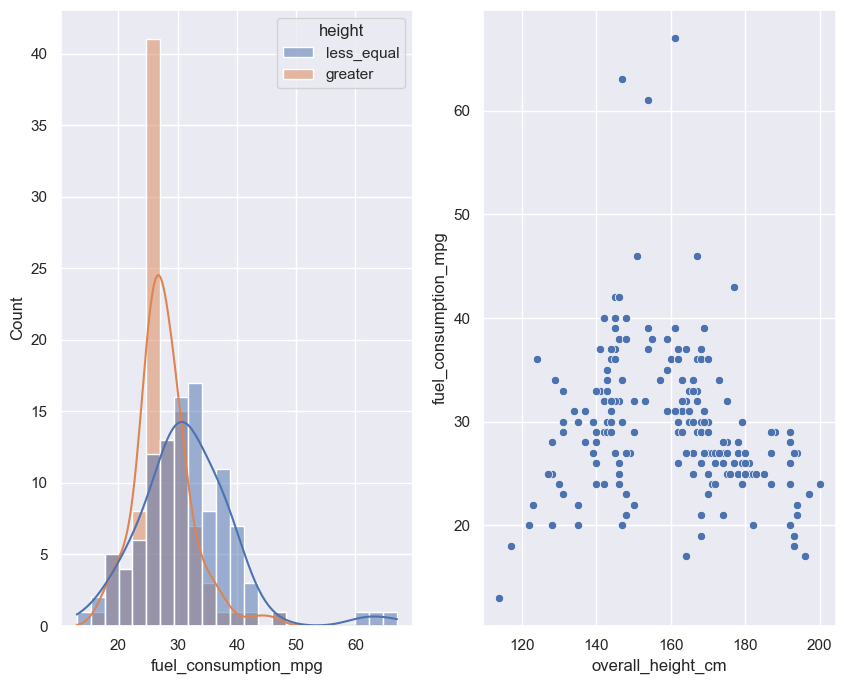

In [87]:
fig, axs = plt.subplots(ncols = 2) #divide plot into 2 columns
sns.histplot(data = height_subset, x = "fuel_consumption_mpg", hue="height", ax = axs[0], kde = True) #create histogram
sns.scatterplot(data = auto_df, x = 'overall_height_cm', y = "fuel_consumption_mpg", ax = axs[1]) #create a scatter plot

3. Apply ANOVA and Tukey's HSD test to the miles per gallon to compare the fuel economy of autos for different vehicle classes. Restrict the analysis to just the `vehicle_class` categories having 10 or more cars in the data. Note that ANOVA and Tukey's HSD are **two separate tests**! <span style="color:red" float:right>[5 point]</span>

ANOVA tests whether there are any significant differences between any of the categories: $H_0: $ are categories have the same mean mpg, and $H_1: $ at least one category has a different mean mpg. If the p-value for ANOVA is significant, then we can perform a Tukey's HSD test to see which categories are significantly different from each other.

In [90]:
#Found which vehicle.count more than 10
vehicle_count = auto_df["vehicle_class"].value_counts() >= 10
#restricted list to only true vehicles
vehicle_count = vehicle_count[vehicle_count]
vehicle_count #print to check

vehicle_class
SUV: Small       True
SUV: Standard    True
Mid-size         True
Compact          True
Full-size        True
Subcompact       True
Two-seater       True
Name: count, dtype: bool

In [91]:
#create a subset from master df of only 2 columns
vehicle_subset = auto_df.loc[:,["vehicle_class","fuel_consumption_mpg"]]
#recreate subset for when the class count > 10
vehicle_subset = vehicle_subset.loc[vehicle_subset["vehicle_class"].isin(vehicle_count.index),:]
vehicle_subset.head() #print to check
#vehicle_subset.vehicle_class.value_counts() #check if filtered correctly

,vehicle_class,fuel_consumption_mpg
0,Compact,33
1,SUV: Small,25
2,SUV: Small,29
3,Compact,29
4,SUV: Small,30


<Axes: xlabel='vehicle_class', ylabel='fuel_consumption_mpg'>

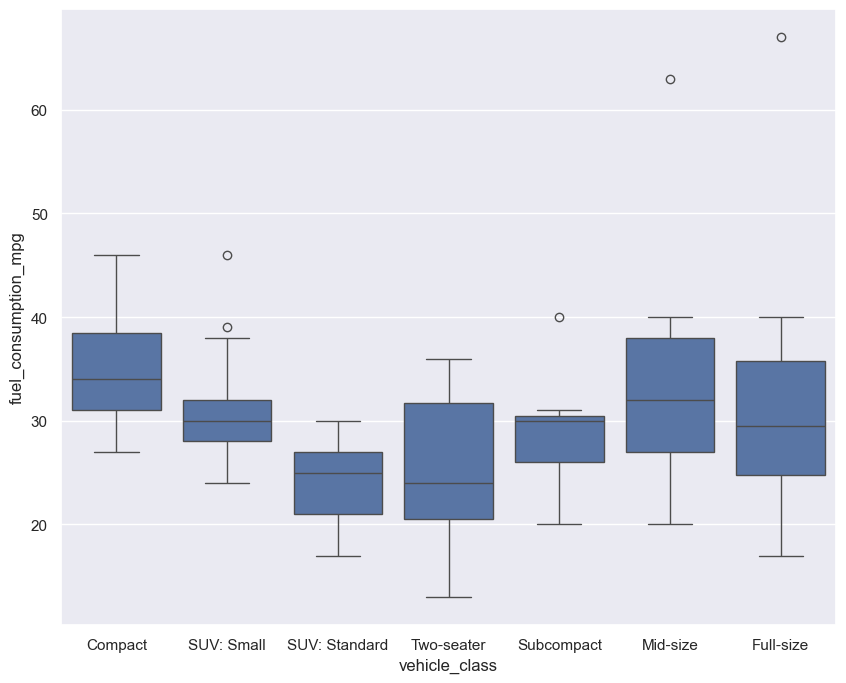

In [166]:
#Graphical check
#sns.barplot(data = vehicle_subset, x = "vehicle_class", y = "fuel_consumption_mpg")
sns.boxplot(data = vehicle_subset, x = "vehicle_class", y = "fuel_consumption_mpg")

In [182]:
#problem_solving a classmates problem
#vehicle_subset.describe()
#vehicle_subset["vehicle_class"].value_counts()
#vehicle_subset.groupby("vehicle_class").mean()
#vehicle_subset.loc[vehicle_subset["vehicle_class"]=="Two-seater",:].sort_values("fuel_consumption_mpg")
#auto_df.iloc[125,:]
auto_df.loc[auto_df["vehicle_class"]=="Two-seater",["make","short_model_name","fuel_consumption_mpg"]]

,make,short_model_name,fuel_consumption_mpg
8,aston martin,vantage,25
17,audi,r8,20
34,bmw,z4,33
47,chevrolet,corvette,22
106,jaguar,f-type,23
125,lamborghini,aventador,13
126,lamborghini,huracan,18
148,mazda,mx-5,36
172,porsche,718,28
189,toyota,gr,34


In [94]:
alpha = 0.05
#Apply formal ANOVA test
    #H_0: all categories have the same mean mpg
    #H_A: at least one category has a different mean mpg
#statsmodels > formula.api.ols > create a model from a formula and dataframe
    #fitting models using r-style formulas ##C() = categorical variables
model = ols('fuel_consumption_mpg ~ C(vehicle_class)', data = vehicle_subset).fit() #'col_in ~ C(col_out)', data = df
anova_table = sm.stats.anova_lm(model)
print(anova_table)

    #look up critical t-statistic (in scipy)
tstat_crit = scipy.stats.t.ppf(alpha, 6.0)
print()
print("Critical t-statistic",round(tstat_crit,2))

                     df       sum_sq     mean_sq          F        PR(>F)
C(vehicle_class)    6.0  2283.859709  380.643285  10.149006  1.289272e-09
Residual          174.0  6525.952446   37.505474        NaN           NaN

Critical t-statistic -1.94


In [162]:
print(sm.__version__)

0.14.2


Because both 1) the F statistic is fairly large and 2) the p-value is small, we can reject the null hypothesis.
There, we can conclude that there are significant differences between the groups.

In [96]:
#Apply formal Tukey's test _IF_ the p-value for ANOVA is significant
Tukey_HSD = pairwise_tukeyhsd(vehicle_subset['fuel_consumption_mpg'], vehicle_subset['vehicle_class'])
print(Tukey_HSD)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
      Compact     Full-size  -3.0376 0.7968  -9.4724  3.3973  False
      Compact      Mid-size  -1.8947 0.9497  -7.4551  3.6656  False
      Compact    SUV: Small  -4.2332 0.1176  -8.9978  0.5314  False
      Compact SUV: Standard -10.7866    0.0 -15.9429 -5.6303   True
      Compact    Subcompact  -6.3493 0.0955 -13.2709  0.5724  False
      Compact    Two-seater  -9.6947 0.0015 -16.8322 -2.5573   True
    Full-size      Mid-size   1.1429 0.9978  -4.9556  7.2413  False
    Full-size    SUV: Small  -1.1956 0.9944  -6.5785  4.1873  False
    Full-size SUV: Standard   -7.749 0.0016 -13.4815 -2.0166   True
    Full-size    Subcompact  -3.3117  0.831 -10.6726  4.0492  False
    Full-size    Two-seater  -6.6571 0.1248 -14.2214  0.9071  False
     Mid-size    SUV: Small  -2.3385  0.668   -6

This shows in detail which pairs had a significant enough difference. 

- True: You can reject the null hypothesis. 
- False: You fail to reject the null hypothesis. 

There are 21 different combinations, where 15 failed (and 6 passed). 
It's interesting that about 71% of the pairs failed to reject the null. This means that, overall, Tukey's suggests there is not a significant enough difference. This is opposite from ANOVA, which says, yes there is a significant difference. 

Why the discrepancy? 

4. Graphically explore the differences in mileage of the cars with different body styles. If any of these relationships are statistically significant (as suggested by Tukey's HSD), examine the sample size and decide if they should be considered practically significant. <span style="color:red" float:right>[5 point]</span>

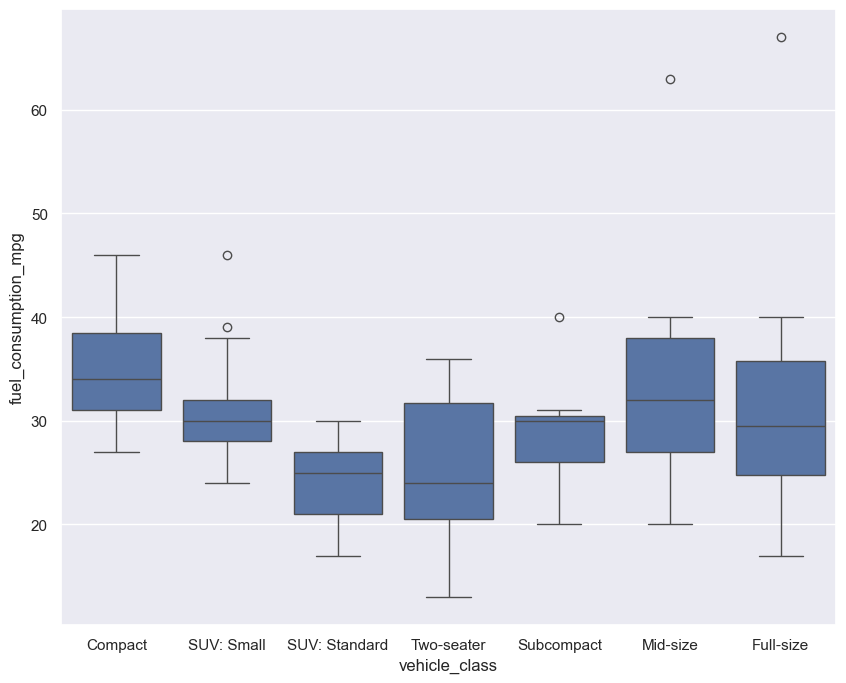

In [99]:
#Graphically explore the differences in mileage vs body styles
sns.boxplot(x = 'vehicle_class', y = 'fuel_consumption_mpg', data = vehicle_subset);

In [100]:
vehicle_subset["vehicle_class"].value_counts()

vehicle_class
SUV: Small       65
SUV: Standard    37
Mid-size         25
Compact          19
Full-size        14
Subcompact       11
Two-seater       10
Name: count, dtype: int64

True: Statistically significant (according to Tukey's)

Question: Is the sample size big enough to be significant? 

Answer: You need to determine 1) its statistical POWER and 2) its EFFECT SIZE. 

1. Compact: SUV  Standard = 19 + 37 = 56
2. Compact: Two-seater = 19 + 10 = 29
3. Full-size: SUV  Standard = 14 + 37 = 51
4. Mid-size: SUV  Standard = 25 + 37 = 62
5. Mid-size: Two-seater = 25 + 10 = 35
6. SUV  Small: SUV  Standard = 65 + 37 = 102

In [102]:
"""alpha = 0.05
#Depends on coefficient of determination (aka % variance explained by model)
##eta_sq = SS_between / SS_total

#Depends on effect size, or Cohen's f, or square root of f2
##f = sqrt(SS_between / (N * sigma^2))
    #SS_between = between-groups sum of squares
    #N = total sample size
    #sigma^2 = MSE, mean square error, aka within-groups variance
##f = sqrt(eta_sq / (1 - eta_sq))
    #eta_sq = measure of proportion of variance in the dependent variable that is explained by the independent variable
##f = sqrt(SS_between / SS_within)

#FTestAnovaPower: Statistical Power calculations F-test for one factor balanced ANOVA
##FTestAnovaPower.power(effect_size, nobs, alpha, k_groups=2)
    #nobs = sample size, number of observation
what = statsmodels.stats.power.FTestAnovaPower.power("""

#Essentially, now that its two groups, it becomes a ttest.#

"alpha = 0.05\n#Depends on coefficient of determination (aka % variance explained by model)\n##eta_sq = SS_between / SS_total\n\n#Depends on effect size, or Cohen's f, or square root of f2\n##f = sqrt(SS_between / (N * sigma^2))\n    #SS_between = between-groups sum of squares\n    #N = total sample size\n    #sigma^2 = MSE, mean square error, aka within-groups variance\n##f = sqrt(eta_sq / (1 - eta_sq))\n    #eta_sq = measure of proportion of variance in the dependent variable that is explained by the independent variable\n##f = sqrt(SS_between / SS_within)\n\n#FTestAnovaPower: Statistical Power calculations F-test for one factor balanced ANOVA\n##FTestAnovaPower.power(effect_size, nobs, alpha, k_groups=2)\n    #nobs = sample size, number of observation\nwhat = statsmodels.stats.power.FTestAnovaPower.power("

In [103]:
test_1 ={"vehicle_class": ["Compact","SUV: Standard"], "sample_size": [19,37]}
test_1 = pd.DataFrame(data=test_1)
print(test_1)

test_1.iloc[0,1]

   vehicle_class  sample_size
0        Compact           19
1  SUV: Standard           37


19

In [104]:
class Vehicle: 
    def __init__(self, type, size):
        self.type = type 
        self.size = size

#Create samples
cars_compact = Vehicle("Compact", 19)
cars_suv_standard = Vehicle("SUV: Standard", 37)
cars_two_seater = Vehicle("Two-seater", 10)
cars_full_size = Vehicle("Full-size", 14)
cars_mid_size = Vehicle("Mid-size", 25)
cars_suv_small = Vehicle("SUV: Small", 65)

cars_compact.type

'Compact'

In [105]:

test_1 = ["Compact","SUV: Standard", 19, 37]
test_2 = ["Compact","Two-seater", 19, 10]
test_3 = ["Full-size","SUV: Standard", 14, 37]
test_4 = ["Mid-size","SUV: Standard", 25, 37] 
test_5 = ["Mid-size","Two-seater", 25, 10]
test_6 = ["SUV: Small", "SUV: Standard", 65, 37]
tests = [test_1, test_2, test_3, test_4, test_5, test_6]
power_list = []

for each in tests: 
    mean_1 = vehicle_subset.loc[vehicle_subset["vehicle_class"]==each[0],"fuel_consumption_mpg"].mean()
    mean_2 = vehicle_subset.loc[vehicle_subset["vehicle_class"]==each[1],"fuel_consumption_mpg"].mean()
#mean_1 = vehicle_subset.loc[vehicle_subset["vehicle_class"]=="Compact","fuel_consumption_mpg"].mean()
#mean_2 = vehicle_subset.loc[vehicle_subset["vehicle_class"]=="SUV: Standard","fuel_consumption_mpg"].mean()
    standard_deviation = np.std(vehicle_subset.loc[vehicle_subset["vehicle_class"].isin(each[0:1]),"fuel_consumption_mpg"])
    effect_size = (mean_1 - mean_2) / standard_deviation
    nobs1 = each[2]
    alpha = 0.05
    ratio = each[3] / each[2]

    power = statsmodels.stats.power.TTestIndPower().power(effect_size, nobs1, alpha, ratio)
    power_list.append(power)

print(power_list)
print(0.9999074165600722) #answer for test_1

[1.0, 0.9946082202528148, 0.548033805690628, 0.9764291054508333, 0.6564021980856013, 1.0]
0.9999074165600722


   
Note that to get full grade, for graphical tests you should include commentary on what your plot is showing. For formal tests should include the following:
- begin by naming the test you are using
- begin by clearly stating the null and alternative hypotheses
- run the test and report the statistic and p-value
- based on the p-value you should state the conclusion

# End of assignment